In [1]:
!pip install git+https://github.com/huggingface/transformers.git datasets

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-ebuxv1mp
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-ebuxv1mp
  Resolved https://github.com/huggingface/transformers.git to commit 66f29aaaf55c8fe0c3dbcd24beede2ca4effac56
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.50.0.dev0-py3-none-any.whl size=10875632 sha256=a134d4c4888ef64795e4b79d378c456f7ae79eb954860287bfbf649e5383773c
  Stored in directory: /tmp/pip-ephem-wheel-cache-h7ix79mr/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0


In [2]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from datasets import Dataset as HFDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

csv_path = "/kaggle/input/emotion-product/balanced_dataset.csv"
dataframe = pd.read_csv(csv_path)
dataframe["text"] = (
    dataframe["Product Name"] + " [SEP] " +
    dataframe["Rating"].astype(str) + " [SEP] " +
    dataframe["Review"] + " [SEP] " +
    dataframe["Product Category"] + " [SEP] " +
    dataframe["Data Source"] + " [SEP] " +
    dataframe["Sentiment"]
)

columns_to_remove = ['Rating', 'Product Name', 'Product Category', 'Data Source', 'Review', 'Sentiment']
dataframe = dataframe.drop(columns=columns_to_remove)
dataset_hf = HFDataset.from_pandas(dataframe)
label_mapping = {"Happy": 0, "Love": 1, "Sadness": 2, "Anger": 3, "Fear": 4}

def encode_labels(example):
    return {"label": label_mapping[example["Emotion"]]}

dataset_hf = dataset_hf.map(encode_labels)
dataset_hf = dataset_hf.remove_columns(["Emotion"])

split_dataset = dataset_hf.train_test_split(test_size=0.3, seed=42)
train_dataset = split_dataset["train"]
temp_dataset = split_dataset["test"]
temp_split = temp_dataset.train_test_split(test_size=1/3, seed=42)
test_dataset = temp_split["train"]
validation_dataset = temp_split["test"]


Map:   0%|          | 0/78130 [00:00<?, ? examples/s]

In [3]:
class TextDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.encodings = tokenizer(data['text'], truncation=True, padding=True,
                                   max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(data['label'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [4]:
model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# 7. Create DataLoaders
train_text_dataset = TextDataset(train_dataset, tokenizer)
val_text_dataset = TextDataset(validation_dataset, tokenizer)
test_text_dataset = TextDataset(test_dataset, tokenizer)

train_loader = DataLoader(train_text_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_text_dataset, batch_size=16)
test_loader = DataLoader(test_text_dataset, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 20
early_stopping_patience = 3

train_losses, val_losses, val_accuracies = [], [], []
best_val_loss = float('inf')
stopping_counter = 0


In [6]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation step
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()
            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == batch['labels']).sum().item()
            total += batch['labels'].size(0)

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.4f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        stopping_counter = 0
    else:
        stopping_counter += 1
        if stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

Epoch 1: Train Loss=0.5612, Val Loss=0.4575, Val Acc=0.8125
Epoch 2: Train Loss=0.4158, Val Loss=0.4088, Val Acc=0.8335
Epoch 3: Train Loss=0.3480, Val Loss=0.4038, Val Acc=0.8380
Epoch 4: Train Loss=0.2845, Val Loss=0.4139, Val Acc=0.8385
Epoch 5: Train Loss=0.2185, Val Loss=0.4872, Val Acc=0.8341
Epoch 6: Train Loss=0.1736, Val Loss=0.5348, Val Acc=0.8346
Early stopping triggered.


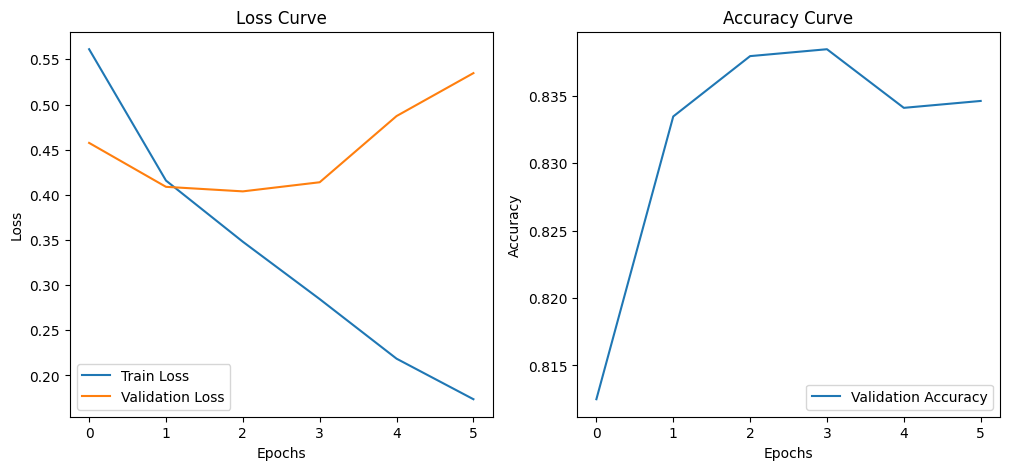

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

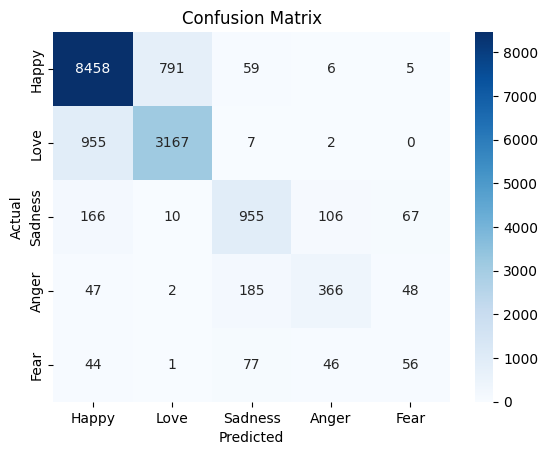

Classification Report:
              precision    recall  f1-score   support

       Happy       0.87      0.91      0.89      9319
        Love       0.80      0.77      0.78      4131
     Sadness       0.74      0.73      0.74      1304
       Anger       0.70      0.56      0.62       648
        Fear       0.32      0.25      0.28       224

    accuracy                           0.83     15626
   macro avg       0.69      0.64      0.66     15626
weighted avg       0.83      0.83      0.83     15626



In [8]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=1)
        y_true.extend(batch['labels'].cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_mapping.keys()))


In [9]:
# Save the model /kaggle/working/
model.save_pretrained('/kaggle/working/modernbert_karib')
tokenizer.save_pretrained('/kaggle/working/modernbert_karib')

('/kaggle/working/modernbert_karib/tokenizer_config.json',
 '/kaggle/working/modernbert_karib/special_tokens_map.json',
 '/kaggle/working/modernbert_karib/tokenizer.json')

In [10]:
# Load model and tokenizer
model_path = "/kaggle/working/modernbert_karib"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Ensure model is in evaluation mode
model.eval()

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

In [11]:
# Reverse label mapping (index to emotion)
index_to_emotion = {v: k for k, v in label_mapping.items()}

In [12]:
def predict_emotion(text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted label
    probs = F.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()

    # Map index to emotion
    return index_to_emotion[predicted_class]



In [13]:
import torch.nn.functional as F

In [14]:
# Example usage
review = "Good product"
predicted_emotion = predict_emotion(review, model, tokenizer)
print(f"Predicted Emotion: {predicted_emotion}")

Predicted Emotion: Happy


In [15]:
# Example usage
review = "Not good"
predicted_emotion = predict_emotion(review, model, tokenizer)
print(f"Predicted Emotion: {predicted_emotion}")

Predicted Emotion: Sadness
